## Задание 1 - Обработка логов

# Задание

Взять произвольный лог следующего формата(можно скачать какой-нибудь из интернета):
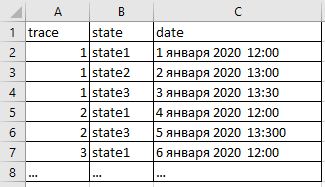
Получить DataFrame всех возможных ребер в таком логе (state1-ststate2, state1-state3 итд)

Необходимо написать алгоритм сбора статистики по логу:
1)      количество проходов по ребру(всего)
2)      количество уникальных trace, которые прошли по этому ребру
3)      min,max, avg по времени для каждого ребра

В итоге получится примерно такой DataFrame
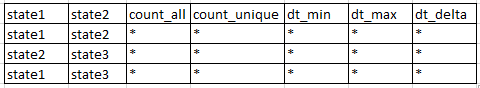

### Загружаем и проверяем данные

In [34]:
import pandas as pd
import numpy as np
import datetime
import cv2  # библ-ка opencv для второго задания
import easyocr  # библ-ка для второго задания
import imutils  # библ-ка для второго задания

from datetime import date,timedelta
from matplotlib import pyplot as pl

In [2]:
df = pd.read_csv('C:\\Users\\anech\\Desktop\\Учёба\\Яндекс_практикум\\DataSets\\logs_exp.csv', sep='\t')

Для исследования взяты логи мобильного приложения, столбцы:
- EventName - отражает этапы работы с приложением, соответствует **state** в нашем случае;
- DeviceIDHash - отражает пользователей, будем использовать как trace;
- EventTimestamp - дата&время события;
- ExpId - группа, в нашем случае не понадобится, удалим эту колонку.

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


- размер таблицы 244126 х 4, 
- пропущенных значений в столбцах нет, 
- в столбце EventTimestamp необходимо изменить формат, для корректного отражения даты
- имена столбцов лучше поменять

In [13]:
# меняем названия колонок на более удобные
df = df[['event_name', 'id_dev', 'event_dt']]  #  удаляем ненужную колонку 
df.columns = ['event_name', 'id_dev', 'event_dt']

In [14]:
df["event_dt"] = pd.to_datetime(df["event_dt"], unit="s")  # меняем формат отражения даты
df.head(3)

,event_name,id_dev,event_dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47


In [8]:
print(f'логи представлены за период с {df.event_dt.min()} по {df.event_dt.max()}')

логи представлены за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17


In [9]:
print(f"всего уникальных trace {df['id_dev'].nunique()}")

всего уникальных trace 7551


### добавляем необходимые для расчётов столбцы

добавляем столбец, отражающий время, проведённое на каждом этапе сессии

In [15]:
df['time_on_action'] = df.groupby(['id_dev'])['event_dt'].diff(1)
df.head()

добавим столбец next_step, отражающий следующий шаг клиента после указанного в столбце event_name

In [21]:
df = df.sort_values(by=['id_dev', 'event_dt'], ascending=False)  # сортируем данные по девайсу, дате

df['next_step'] = 0
df.loc[df.id_dev == df.id_dev.shift(+1, axis=0), 'next_step'] = df.event_name.shift(+1, axis=0)  # добавим столбец next_step

df.head(5)

,event_name,id_dev,event_dt,time_on_action,next_step
221438,MainScreenAppear,9222603179720523844,2019-08-07 09:16:20,0 days 00:01:07,0
221412,MainScreenAppear,9222603179720523844,2019-08-07 09:15:13,0 days 00:00:12,MainScreenAppear
221406,MainScreenAppear,9222603179720523844,2019-08-07 09:15:01,0 days 00:00:08,MainScreenAppear
221404,MainScreenAppear,9222603179720523844,2019-08-07 09:14:53,0 days 00:01:16,MainScreenAppear
221366,MainScreenAppear,9222603179720523844,2019-08-07 09:13:37,0 days 00:02:00,MainScreenAppear


In [22]:
# проверим первый id, для того, чтобы убедится в корректности расчётов

df.query("id_dev == 4575588528974610257").sort_values(by='event_dt').head()

,event_name,id_dev,event_dt,time_on_action,next_step
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,NaT,MainScreenAppear
4583,MainScreenAppear,4575588528974610257,2019-08-01 04:30:00,6 days 23:46:24,MainScreenAppear
108616,MainScreenAppear,4575588528974610257,2019-08-04 03:07:11,2 days 22:37:11,OffersScreenAppear
108618,OffersScreenAppear,4575588528974610257,2019-08-04 03:07:50,0 days 00:00:39,MainScreenAppear
108621,MainScreenAppear,4575588528974610257,2019-08-04 03:09:03,0 days 00:01:13,MainScreenAppear


посотрим сколько строк отражают зацикленный процесс - когда текущий и следующий шаги совпадают

In [23]:
print(f'{df.query("event_name == next_step").shape[0]} строк отражают "зацикленный" процесс, это {df.query("event_name == next_step").shape[0]/df.shape[0]:.2%} от общего кол-ва строк')

109270 строк отражают "зацикленный" процесс, это 44.76% от общего кол-ва строк


судя по всему такое может случиться и в банке, поэтому, на всякий случай, оставим все строки для дальнейших расчётов

### посмотрим на каком шаге чаще всего завершается процесс работы с клиентом

---
0 в next_step отражает последний шаг по выбранному trace,  не думаю, что нам нужны эти данные в дальнейшем, но нужно посомтреть какой шаг лидирует в завершении процесса, в дальнейшем эти данные нам могут помочь, важно понимать у кого из клиентов процесс завершился неправильно - не на желаемом нами шаге, это может помочь повысить конверсию

In [24]:
last_step_0 = df.query('next_step == 0')
last_step_0.head(2)

,event_name,id_dev,event_dt,time_on_action,next_step
221438,MainScreenAppear,9222603179720523844,2019-08-07 09:16:20,0 days 00:01:07,0
168449,MainScreenAppear,9221926045299980007,2019-08-05 16:45:59,0 days 00:02:08,0


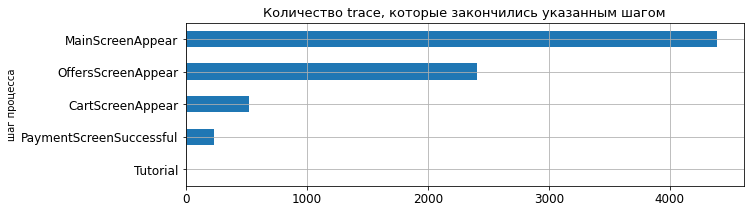

In [25]:
last_step_0.groupby('event_name').agg({'next_step': 'count'}).sort_values(by='next_step').plot(
    kind='barh', 
    figsize=(10,3), 
    legend = False, 
    fontsize = 12,
    xlabel = 'шаг процесса',
    ylabel = 'количество',
    grid=True).set_title('Количество trace, которые закончились указанным шагом',  fontsize = 13);


In [26]:
# удалим эти шаги из основного фрейма
df = df.query('next_step != 0')

### отражение необходимой по заданию информации

In [32]:
intersections = df.groupby([df.event_name, df.next_step]).agg({'id_dev': ['count', 'nunique'], 'time_on_action': ['min', 'max', 'mean']})
intersections.columns = ['count_all', 'count_unique', 'dt_min', 'dt_max', 'dt_avg_delta']
intersections['dt_avg_delta'] = intersections['dt_avg_delta'].round('s')  # округляем время до секунд

In [33]:
(intersections.style 
 .highlight_min(color='yellowgreen', subset=['count_all', 'count_unique', 'dt_min', 'dt_max', 'dt_avg_delta'])
 .highlight_max(color='coral', subset=['count_all', 'count_unique','dt_min', 'dt_max', 'dt_avg_delta']))

    Получены данные в необходимом представлении, наибольшие значения выделены красным, наименьшие - зелёным

## Задание 2 – Распознавание с помощью компьютерного зрения (использовать OpenCV)

# Задание

Необходимо обнаружить печати, определить их координаты и выделить их (печати) контуром. Также определить присутствуют ли на листе печати исполнителя и заказчика, либо только одной организации. Если обнаружена только одна печать, определить, кому она принадлежит. Ответ может выглядеть в виде подобного списка: 
1. Лист1: исполнитель – Да, заказчик – Да
2. Лист2: исполнитель – Нет, заказчик – Да
3. ...

https://drive.google.com/drive/folders/1ADUOv75wzJ2ENH093bRwzOU1tM9GYl41?usp=sharing

stamp1.jpeg:


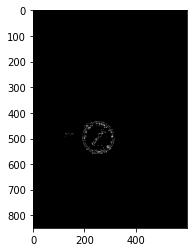

stamp1: исполнитель – Да, заказчик – Да


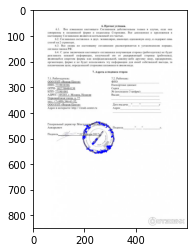

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 
stamp2.jpg:


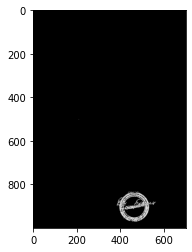

stamp2: исполнитель – Нет, заказчик – Да


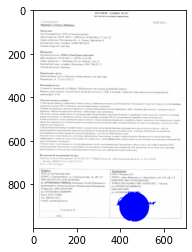

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 
stamp3.jpg:


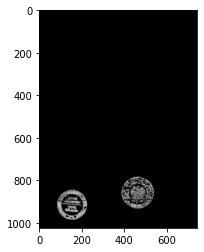

stamp3: исполнитель – Да, заказчик – Да


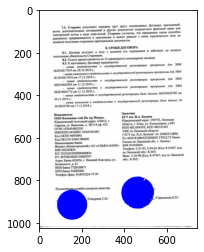

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 
stamp4.jpg:


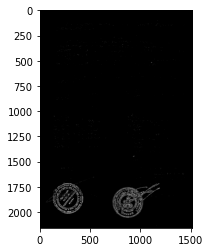

stamp4: исполнитель – Да, заказчик – Да


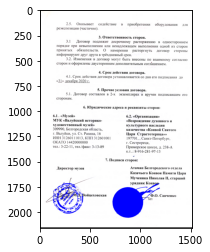

--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 


In [89]:
# перебираем изображения, для каждого определяем область печати и наличие её со стороны исполнителя/заказчика
# performer and client

# https://habr.com/ru/company/directum/blog/486476/
def colored_mask(img, threshold = -1):
   # Размытие для удаления мелких шумов.
   denoised = cv2.medianBlur(img, 3)
   cv2.imwrite('denoised.bmp', denoised)

   # Сохранение в ЧБ для получения маски.
   gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
   cv2.imwrite('gray.bmp', gray)

   # Получение цветной части изображения.
   adaptiveThreshold = threshold if threshold >= 0 else cv2.mean(img)[0]
   color = cv2.cvtColor(denoised, cv2.COLOR_BGR2HLS)
   mask = cv2.inRange(color, (0, int(adaptiveThreshold / 6), 60), (180, adaptiveThreshold, 255))

   # Создание маски цветной части изображения.
   dst = cv2.bitwise_and(gray, gray, mask=mask)
   cv2.imwrite('colors_mask.bmp', dst)
   return dst


path = 'C:\\Users\\anech\\Desktop\\stamp_checking\\docs\\'
list_contracts = ['stamp1.jpeg', 'stamp2.jpg',  'stamp3.jpg', 'stamp4.jpg']

for i in list_contracts:  # считываем изображение
    img = cv2.imread(path + i)
    
    print(i + ':')   
    img_2 = colored_mask(img)    
    pl.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)) # переводим изображение в формат RGB
    pl.show()
        
    
    ## находим контуры
    contours, _ = cv2.findContours(image=img_2.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)        
    # reverse чтобы сортировать в нужном порядке(по соответствию) и берём из них первые 6
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)#[:6]    
    filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)
    #  рисуем и заполняем контур
    cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
    ## закрытые контуры
    kernel = np.ones((3,3),np.uint8)
    closedCircle = cv2.morphologyEx(filteredCircle, cv2.MORPH_CLOSE, kernel, iterations=1)
    filteredContours, _ = cv2.findContours(image=closedCircle.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    circleContours = []
    for index, contour in enumerate(filteredContours):
        perimeter = cv2.arcLength(contour,True)
        # True т.к. мы ищем только закрытые контуры
        approxPoints = cv2.approxPolyDP(contour, 5, True)
        if len(approxPoints) > 3:
            circleContours.append(contour)
    out = img.copy()
    cv2.drawContours(image=out, contours=circleContours, contourIdx=-1, color=(255,0, 0), thickness=cv2.FILLED, lineType=cv2.LINE_AA)
        
    
    
    centres = []  
    for j in contours: 
      moment = cv2.moments(j) 
      if moment["m00"] != 0: 
        x = int(moment['m10']/moment['m00']) 
        y = int(moment['m01']/moment['m00']) 
      else: continue 
      centres.append([x, y]) 
  

    
    performer, client = False, False
    for x, y in centres:
        if x > img.shape[1]//2:
            client = True
        if x < img.shape[1]//2:
            performer = True
        if performer and client:
            break
            
    if performer and client:
        print(f'{i.replace(".jpg", "").replace(".jpeg", "")}: исполнитель – Да, заказчик – Да')
    elif performer:
        print(f'{i.replace(".jpg", "").replace(".jpeg", "")}: исполнитель – Да, заказчик – Нет')
    elif client:
        print(f'{i.replace(".jpg", "").replace(".jpeg", "")}: исполнитель – Нет, заказчик – Да')    
    
    pl.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) # переводим изображение в формат RGB
    pl.show()   
    print('--- '*15)

### Вывод

Это задание для меня самое сложное, ранее с OpenCV я не работала, но разбираться интересно, не смотря на то, что код похож на Франкенштейна :)

Частично код отрабатывает верно, но я пока не разобралась как решить в коде такие проблемы как:
- определение принадлежности печати, когда она находится посередине листа - код не определяет она относится к исполнителю или к заказчику
- нахождение кол-ва печатей на листе, чтоб при наличии только двух печатей отражать наличие штампа как исполнителя, так и заказчика
- работа с gif изображениями

## задание 3



# Задание

Схема базы данных на MSSQL сервер состоит из 4 таблиц:

- ORGANIZATIONS – список организаций
- CREDIT_Portfolio – кредитный портфель
- DOCS_Numbers – номера документов организации
- DOCS_Data – данные из документов


**Таблица ORGANIZATIONS содержит:** номер организации (ID_ORG), ИНН (INN), наименование организации (CLIENT_NAME),

**Таблица CREDIT_Portfolio содержит:** номер кредита(ID_CREDIT), код подразделения, выдавшего кредит (DIVISION), ИНН (INN), тип кредита (CREDIT_TYPE), сумму кредита (CREDIT_SUM) и процентную ставку (CREDIT_RATE)

**Таблица DOCS_Numbers содержит:** номер документа (ID_DOCS), номер организации (CODE), тип документа(DOCS_TYPE) и дата документа (DOCS_DATE)

**Таблица DOCS_Data содержит:** уникальный номер записи (ID_DATA), номер документа (ID_DOCS), строка документа (ROW_DOCS), значение строки (NM)

--- 

**Условие запроса:** 
- Требуется получить среднюю процентную ставку для организации и вывести значение из документа «Финансовая отчетность» из строки с номером «2000».

In [ ]:
# создаём CTE куда заносим номер организации и соответствующее ей значение из документа «Финансовая отчетность» 
# из строки с номером «2000»
# объединяем таблицы по id документа

# получаем наименование организации  и соответствующую ей среднюю процентную ставку

# объединяем данные и получаем необходимую информацию


query = '''
WITH documents AS (
    SELECT dn.code, 
        dd.nm AS row_2000_fin_st
    FROM DOCS_Numbers AS dn LEFT JOIN DOCS_Data AS dd ON dn.id_docs = dd.id_docs
    WHERE dn.docs_type = "Финансовая отчетность" AND dd.row_docs = 2000),
    
organisation_rate AS (
    SELECT o.client_name AS organisation, 
        avg(cp.credit_rate) as avg_rate
    FROM organisations AS o 
        LEFT JOIN credit_portfolio AS cp ON o.inn = cp.inn 
    GROUP BY o.client_name)


SELECT or.organisation, 
       or.avg_rate,
       d.row_2000_fin_st
FROM organisation_rate AS or 
    LEFT JOIN documents AS d ON o.id_org = dn.code       

'''